# Summary and presentation of method using Fourier Transforms

## Libraries, Mnist dataset and precomputed data to centroid distances vectors

In [1]:
from visualizations import *
import numpy as np
import pandas as pd
import warnings
from math import tau
import matplotlib.pyplot as plt
from scipy.integrate import quad
warnings.filterwarnings('ignore')

In [2]:
data = np.loadtxt("./../DATA/digits2k_pixels.data.gz", ndmin=2)/255.0
data.shape = (data.shape[0], int(np.sqrt(data.shape[1])), int(np.sqrt(data.shape[1])))
labels = np.loadtxt("./../DATA/digits2k_pixels.labels.gz", dtype='int')
labels_true = labels

In [3]:
centroid_distances = np.load('centroid_distances.npy') # thats our frame of 30-dimensional points to compare with each other via clustering

labels[i] correspond to centroid_distances[i]

## How centroid distances vectors are created?

Generating methods are all written in 'Generate_depth10_allPixels' notebook. Here we will only cover the theory behind it.

As a sample we will take one of the MNIST digits

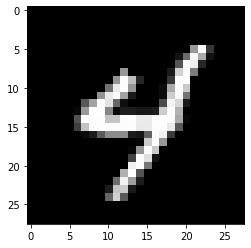

In [4]:
i = 115
plt.imshow(data[i,:,:], cmap=plt.get_cmap("gray"))

Four is a fine example. Then we need a function to get pixels to binary values.

In [5]:
def onlyBlackWhite(array, percentage = 0.3):
    result = array.copy()
    quantile = np.quantile(result[result>0], percentage)
    for i in range(len(result)):
        for j in range(len(result[0])):
            if (result[i,j] < quantile):
                result[i,j] = 0
            else:
                result[i,j] = 1
    return result

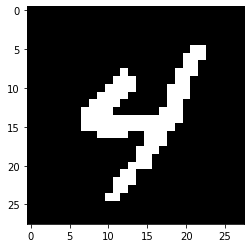

In [6]:
digit = onlyBlackWhite(data[i,:,:])
plt.imshow(digit, cmap=plt.get_cmap("gray"))

And here it is. Now we get points defining contour of the digit. And we center it so all the digits are in [-10,10]x[-10,10]. Of course in some instances, we get more than one contour. In such cases we take the one with most points.

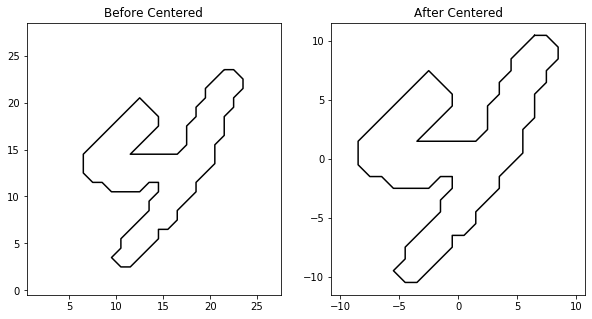

In [7]:
time_table, x_table, y_table = create_close_loop(digit)

Now let's describe this shape with Fourier Transform. Already known functions:

In [8]:
def f(t, time_table, x_table, y_table):
    return interp(t, time_table, x_table) + 1j*interp(t, time_table, y_table)

def coef_list(time_table, x_table, y_table, order=10):
    """
    Counting c_n coefficients of Fourier series, of function aproximated by points (time_table, x_table + j*y_table)
    of order of magnitude = order
    """
    coef_list = []
    for n in range(-order, order+1):
        real_coef = quad(lambda t: np.real(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        imag_coef = quad(lambda t: np.imag(f(t, time_table, x_table, y_table) * np.exp(-n*1j*t)), 0, tau, limit=100, full_output=1)[0]/tau
        coef_list.append([real_coef, imag_coef])
    return np.array(coef_list)

And now functions to generate points from Fourier coefficients:

In [9]:
def DFT(t, coef_list, order=10):
    """
    get points of Fourier series aproximation, where t is a time argument for which we want to get (from range[0, tau])
    """
    kernel = np.array([np.exp(-n*1j*t) for n in range(-order, order+1)])
    series = np.sum( (coef_list[:,0]+1j*coef_list[:,1]) * kernel[:])
    return np.real(series), np.imag(series)

def GenerateShapePoints(coef_list, n=100):
    time_space = np.linspace(0, tau, n)
    x_DFT = [DFT(t, coef)[0] for t in time_space]
    y_DFT = [DFT(t, coef)[1] for t in time_space]
    return x_DFT, y_DFT

With these we get an effect presented below. Orange point represents the first point and the following go through the lines counter clockwise.

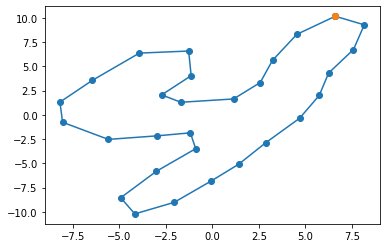

In [10]:
coef = coef_list(time_table, x_table, y_table, order=10)
X, Y = GenerateShapePoints(coef, n=30)
plt.plot(X, Y, '-o')
plt.plot(X[0], Y[0], 'o')

So now points in certain order represent our number. It appears it would be much easier and efficient to reduce our input to one column rather than keep it in 2 columns of 30 rows.

In fact, the most efficient way of comparing shapes described like that to each other is by comparing distances of each point(if they are kept in time order like in our case) from the centroid of the image. Centroid is of course a mean of all points. To dive deeper into the topic please take a look at the article below.

https://cis.temple.edu/~lakamper/courses/cis9601_2009/etc/fourierShape.pdf

In [11]:
# creating centroids
Xc = np.mean(X)
Yc = np.mean(Y)

Below we show you few steps to 

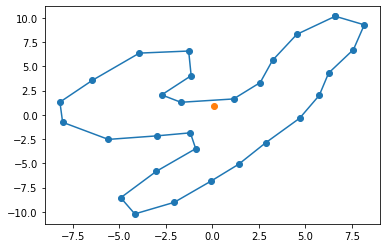

In [12]:
plt.plot(X, Y, '-o')
plt.plot(Xc, Yc, 'o')

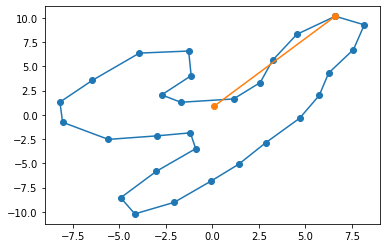

In [13]:
plt.plot(X, Y, '-o')
plt.plot([Xc, X[0]], [Yc, Y[0]], '-o')

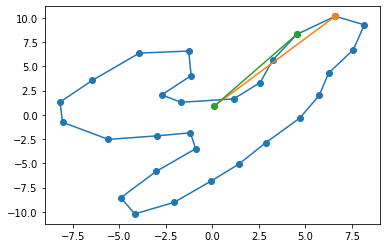

In [14]:
plt.plot(X, Y, '-o')
plt.plot([Xc, X[0]], [Yc, Y[0]], '-o')
plt.plot([Xc, X[1]], [Yc, Y[1]], '-o')

And so on.

And now a digit is represented with vector, of distances, of all points from centroid.

## Proof, that it works?

Early on we realised that silhoutte score is kind of irrelevant to how many clusters we need. Then the idea came up to create our own scoring, of telling how much a cluster is by average dominated by the digits of same kind(using true labels).

In [15]:
def dominanceOfPredictedClusters(labels_pred, labels_true):
    clusters = np.unique(labels_pred)
    cluster_dominance = []
    cluster_sizes = []
    N = len(labels_pred)
    for l in clusters:
        labels_in_cluster = np.bincount(labels[np.where(labels_pred==l)])
        cluster_dominance.append(np.max(labels_in_cluster)/np.sum(labels_in_cluster))
        cluster_sizes.append(len(labels[np.where(labels_pred==l)]))
    # mean needs to be counted with wages, to omit situation when all but one clusters are super balanced
    return np.average(cluster_dominance, weights=cluster_sizes)
# the closer it is to one, the more dominated the clusters are, meaning the better is our model

def count_clustering_scores(X, cluster_num, model, labels_true):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        model_instance.fit(X)
        dominance = dominanceOfPredictedClusters(model_instance.labels_, labels_true)
        scores.append(dominance)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

Also, first tests have shown that Agglomerative algorithm(with default parameters) works best, but we will evaluate more of them in the future.

### Agglomerative (ward) vs MNIST

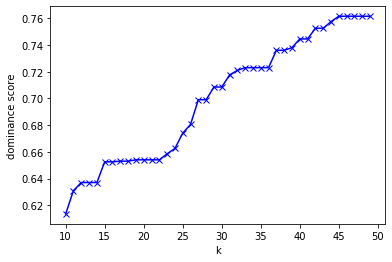

In [16]:
from sklearn.cluster import AgglomerativeClustering

model_test = AgglomerativeClustering
cluster_num_seq = range(10, 50) # minimum 10 clusters
dominance_vec = count_clustering_scores(centroid_distances, cluster_num_seq, model_test, labels)
plt.plot(cluster_num_seq, dominance_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('dominance score')
plt.show()

k = 45 seems to be optimal ammount of clusters(still not too big), and we also need a function to determine labels based on dominance of real label in a cluster

In [17]:
def determineClusterDigit(labels_true, labels_pred, cluster_num):
    real_labels, counts = np.unique(labels[model.labels_ == cluster_num], return_counts=True)
    if len(real_labels) == 0:
        return -1
    return real_labels[np.argmax(counts)]

def assignRealLabels(labels_pred, labels_true):
    label_mapping = dict()
    n_clusters = max(labels_pred)+1
    for i in range(n_clusters):
        label_mapping[i] = determineClusterDigit(labels_true, labels_pred, i)
    
    labels_final_prediction = pd.Series(labels_pred)
    labels_final_prediction = labels_final_prediction.map(label_mapping)
    return labels_final_prediction

In [18]:
model = AgglomerativeClustering(n_clusters=45)
model.fit(centroid_distances)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=45,
                        pooling_func='deprecated')

In [19]:
labels_final_prediction = assignRealLabels(model.labels_, labels_true)

Check the score with precision metric for multilabels

In [20]:
from sklearn.metrics import precision_score

precision_score(y_true = labels_true, y_pred = labels_final_prediction, average='micro')

0.7615

Still not exploring the full potential of preprocesing and not checking other algorithms deeply, it seems to be a promising result for further evaluation.

# Extras

### Looking for best precision number of clusters

In [21]:
def precScores(centroid_distances, cluster_num, model_test, labels):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model_test(n_clusters=k)
        model_instance.fit(centroid_distances)
        labels_ass = assignRealLabels(model_instance.labels_, labels)
        prec = precision_score(y_true = labels, y_pred = labels_ass, average='micro')
        scores.append(prec)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

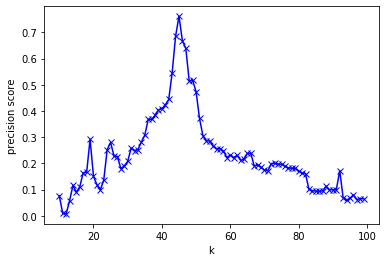

In [22]:
model_test = AgglomerativeClustering
cluster_num_seq = range(10, 100) # minimum 10 clusters
prec_vec = precScores(centroid_distances, cluster_num_seq, model_test, labels)
plt.plot(cluster_num_seq, prec_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('precision score')
plt.show()

What a luck we had, exactly 45 clusters give the best precision score :)

## Affinity

In [23]:
from sklearn.cluster import AffinityPropagation

In [24]:
model = AffinityPropagation()
model.fit(centroid_distances)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [25]:
max(model.labels_)

88

In [26]:
labels_pred = model.labels_
label_mapping = dict()
n_clusters = 89
for i in range(n_clusters):
    label_mapping[i] = determineClusterDigit(labels_true, labels_pred, i)
    
labels_final_prediction = pd.Series(labels_pred)
labels_final_prediction = labels_final_prediction.map(label_mapping)

In [27]:
precision_score(y_true = labels_true, y_pred = labels_final_prediction, average='micro')

0.774